In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [2]:
customers = pd.read_csv("customers.csv")
merchants = pd.read_csv("merchants.csv")
offers = pd.read_csv("offers.csv")
transactions = pd.read_csv("transactions.csv")



In [8]:
# Convert dates
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
offers["start_date"] = pd.to_datetime(offers["start_date"])
offers["end_date"] = pd.to_datetime(offers["end_date"])


In [11]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   offer_id      50 non-null     object        
 1   merchant_id   50 non-null     int64         
 2   offer_type    50 non-null     object        
 3   discount_pct  50 non-null     int64         
 4   start_date    50 non-null     datetime64[ns]
 5   end_date      50 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 2.5+ KB


In [12]:
df = (
    transactions
    .merge(customers, on="customer_id", how="left")
    .merge(merchants, on="merchant_id", how="left")
    .merge(offers, on="merchant_id", how="left")
)

df.head()


transaction_id  customer_id  merchant_id transaction_date  \
0               1          154           14       2024-03-08   
1               2          315            6       2024-04-19   
2               3          489           25       2024-04-30   
3               4           72           12       2024-01-22   
4               5           84           30       2024-04-15   

   transaction_amount offer_applied  age     city_x spend_segment  \
0             2945.47             Y   42    Chennai        Medium   
1             2612.82             N   25      Delhi          High   
2              281.84             N   22  Hyderabad           Low   
3             2286.18             N   51  Bengaluru          High   
4              604.94             N   61     Mumbai        Medium   

  merchant_category     city_y offer_id offer_type  discount_pct start_date  \
0              Food      Delhi      O14   Discount            10 2024-01-08   
1           Grocery     Mumbai       O6   Discount            10 2024-02-13   
2       Electronics  Bengaluru      O25   Discount            15 2024-01-22   
3       Electronics      Delhi      O12   Cashback            20 2024-02-12   
4       Electronics      Delhi      O30   Discount            20 2024-02-01   

    end_date  
0 2024-02-07  
1 2024-03-14  
2 2024-02-21  
3 2024-03-13  
4 2024-03-02


# Compare spend with offer vs without offer 

In [13]:
offer_spend = (
    df.groupby("offer_applied")["transaction_amount"]
    .agg(["count", "mean", "median"])
    .reset_index()
)

offer_spend


offer_applied  count         mean    median
0             N   6956  2599.706288  2591.605
1             Y   3044  2620.820756  2642.085

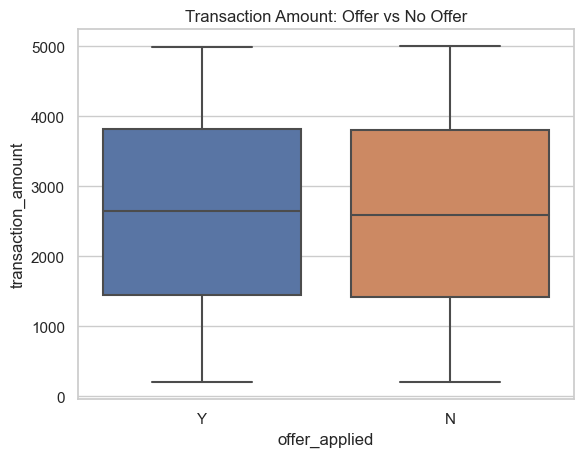

In [14]:
sns.boxplot(x="offer_applied", y="transaction_amount", data=df)
plt.title("Transaction Amount: Offer vs No Offer")
plt.show()


In [15]:
segment_analysis = (
    df.groupby("spend_segment")
    .agg(
        total_txns=("transaction_id", "count"),
        redeemed_txns=("offer_applied", lambda x: (x == "Y").sum()),
        avg_spend=("transaction_amount", "mean")
    )
    .reset_index()
)

segment_analysis


spend_segment  total_txns  redeemed_txns    avg_spend
0          High        2153            626  2598.907887
1           Low        3695           1162  2612.577399
2        Medium        4152           1256  2604.145749

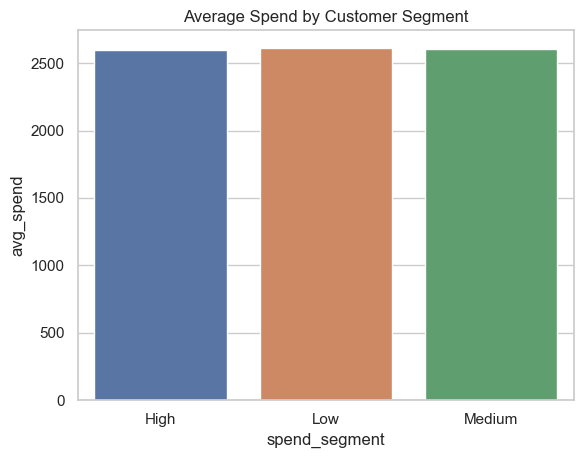

In [16]:
sns.barplot(x="spend_segment", y="avg_spend", data=segment_analysis)
plt.title("Average Spend by Customer Segment")
plt.show()


In [17]:
merchant_perf = (
    df.groupby("merchant_id")
    .agg(
        total_txns=("transaction_id", "count"),
        redeemed_txns=("offer_applied", lambda x: (x == "Y").sum()),
        avg_spend=("transaction_amount", "mean")
    )
    .reset_index()
)

merchant_perf["redemption_rate"] = (
    merchant_perf["redeemed_txns"] / merchant_perf["total_txns"]
)

merchant_perf.sort_values(
    ["redemption_rate", "avg_spend"], ascending=False
).head(10)


merchant_id  total_txns  redeemed_txns    avg_spend  redemption_rate
21           22         197             76  2614.520000         0.385787
33           34         191             66  2562.614346         0.345550
6             7         201             69  2469.743632         0.343284
14           15         169             58  2662.711065         0.343195
41           42         207             71  2537.667391         0.342995
9            10         194             66  2546.859124         0.340206
25           26         207             70  2652.165024         0.338164
37           38         217             72  2574.123641         0.331797
39           40         196             65  2434.031684         0.331633
43           44         218             72  2563.042156         0.330275

In [18]:
offer_type_perf = (
    df.groupby("offer_type")
    .agg(
        total_txns=("transaction_id", "count"),
        redeemed_txns=("offer_applied", lambda x: (x == "Y").sum()),
        avg_spend=("transaction_amount", "mean")
    )
    .reset_index()
)

offer_type_perf


offer_type  total_txns  redeemed_txns    avg_spend
0   Cashback        5275           1589  2606.664929
1   Discount        4725           1455  2605.540279

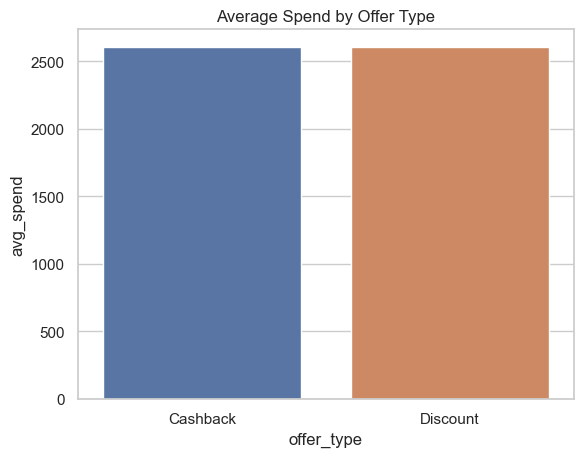

In [19]:
sns.barplot(x="offer_type", y="avg_spend", data=offer_type_perf)
plt.title("Average Spend by Offer Type")
plt.show()


In [22]:
city_perf = (
    df.groupby("city_y")
    .agg(
        total_txns=("transaction_id", "count"),
        redeemed_txns=("offer_applied", lambda x: (x == "Y").sum()),
        avg_spend=("transaction_amount", "mean")
    )
    .reset_index()
)

city_perf.sort_values("redeemed_txns", ascending=False)


city_y  total_txns  redeemed_txns    avg_spend
1    Chennai        2603            811  2559.467768
2      Delhi        2200            658  2672.673150
3  Hyderabad        2227            652  2590.291881
4     Mumbai        1620            515  2649.568204
0  Bengaluru        1350            408  2561.688356